In [215]:
import festim as F
import numpy as np
from two_layer_functions import *
import h_transport_materials as htm

In [216]:
# substrate_diffusivities = htm.diffusivities.filter(material="tungsten").filter(isotope="h").filter(author="frauenfelder")
# D = substrate_diffusivities[0]
# print(D, type(D))

# substrate_recombinations = htm.recombination_coeffs.filter(material="tungsten").filter(isotope="h")
# K_r_substrate = substrate_recombinations[0]
# print(K_r_substrate, type(K_r_substrate))

In [217]:
# substrate SS
# barrier tungsten
params = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e22,  # mol/m3Pa^0.5
    "E_S_barrier": 1.04,  # eV
    "K_r_0_barrier": 3.2e-15,  # m2/s Anderl 1992
    "E_K_r_barrier": 1.16,  # eV Anderl 1992
    "D_0_substrate": 4.1e-7,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1.87e24,  # mol/m3Pa^0.5
    "E_S_substrate": 1.04,  # eV
    "K_r_0_substrate": 5.4e-19,  # m2/s
    "E_K_r_substrate": 15600 / 96491,  # converting to eV from F. WAELBROECK et al
}

# # for playing with parameters
# params = {
#     "D_0_barrier": 1e-7,  # m2/s
#     "E_D_barrier": 0.39,  # eV
#     "S_0_barrier": 1.87e23,  # mol/m3Pa^0.5
#     "E_S_barrier": 1.04,  # eV
#     # "K_r_0_barrier": 3.2e-16,  # m2/s Anderl 1992
#     "E_K_r_barrier": 1.16,  # eV Anderl 1992
#     "D_0_substrate": 1.1e-7,  # m2/s
#     "E_D_substrate": 0.39, # eV
#     "S_0_substrate": 1.87e21,  # mol/m3Pa^0.5
#     "E_S_substrate": 1.04,  # eV
#     "K_r_0_substrate": 5.4e-23,  # m2/s
#     "E_K_r_substrate": 15600 / 96491,  # converting to eV from F. WAELBROECK et al
# }

# params = {
#     "D_0_barrier": 1e-7,  # m2/s
#     "E_D_barrier": 0.39,  # eV
#     "S_0_barrier": 1e22,  # mol/m3Pa^0.5
#     "E_S_barrier": 1.04,  # eV
#     "K_r_0_barrier": 3.2e-15,  # m2/s Anderl 1992
#     "E_K_r_barrier": 1.16,  # eV Anderl 1992
#     "D_0_substrate": 4.1e-7,  # m2/s
#     "E_D_substrate": 0.39,  # eV
#     "S_0_substrate": 5e18,  # mol/m3Pa^0.5
#     "E_S_substrate": 1.04,  # eV
#     "K_r_0_substrate": 5.4e-19,  # m2/s
#     "E_K_r_substrate": 15600 / 96491,  # converting to eV from F. WAELBROECK et al
# }

T = 600  # K
P_up = 100 # Pa
barrier_thick = 3e-6  # m
substrate_thick = 3e-3  # m

results_folder = "results"

times_input = [100, 17000, 8e5]  # s

In [218]:
model, barrier, substrate = create_2_layer_model(params, barrier_thick, substrate_thick)

mesh_2_layer_model(model, barrier_thick, substrate_thick)

set_2_layer_BCs(model, barrier, T=T, P_up=P_up)

set_2_layer_settings(model, results_folder=results_folder, times_input=times_input)

In [219]:
model.initialise()
model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        8.0e+05 s    Elapsed time so far: 0.7 s


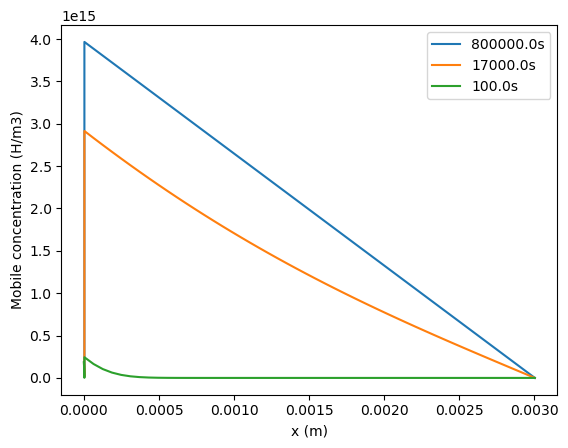

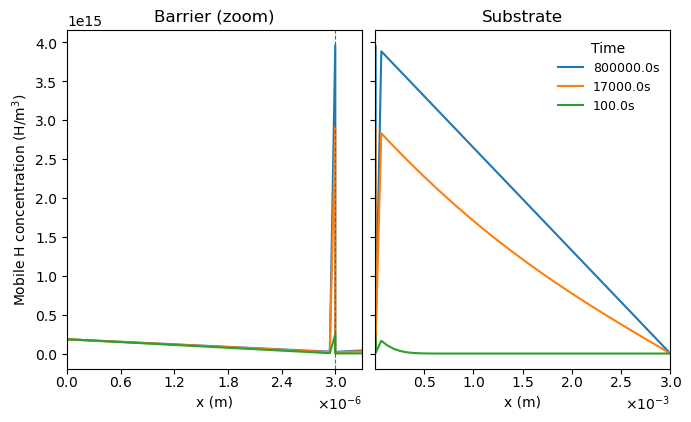

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter

data = np.genfromtxt(
    results_folder + "/mobile_concentration.txt", skip_header=1, delimiter=","
)

plt.plot(data[:, 0], data[:, 3], label=f"{float(times_input[2])}s")
plt.plot(data[:, 0], data[:, 2], label=f"{float(times_input[1])}s")
plt.plot(data[:, 0], data[:, 1], label=f"{float(times_input[0])}s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()





data = np.genfromtxt(results_folder + "/mobile_concentration.txt",
                     skip_header=1, delimiter=",")
data = data[data[:, 0].argsort()] # sort by x

x = data[:, 0]
ys   = [data[:, 3], data[:, 2], data[:, 1]]
labs = [f"{float(times_input[2])}s",
        f"{float(times_input[1])}s",
        f"{float(times_input[0])}s"]

# Taller, less-wide figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True,
                        figsize=(6.8, 6.2), constrained_layout=True)

# Make each axes taller than wide (fallback-safe)
for ax in axs:
    try:
        ax.set_box_aspect(1.15)
    except Exception:
        pass

# Zoom windows
xlims = [
    (0, barrier_thick * 1.1),                        # barrier
    (barrier_thick, barrier_thick + substrate_thick) # substrate
]

# Set up compact tick formatting
fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-3, 3))  # show ×10^k offset instead of long numbers

for ax, xlim in zip(axs, xlims):
    for y, lab in zip(ys, labs):
        ax.plot(x, y, label=lab)
    ax.set_xlabel("x (m)")
    ax.set_xlim(*xlim)
    ax.axvline(barrier_thick, linestyle="--", linewidth=0.8)

    # --- anti-overlap tweaks ---
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))       # adjust number of ticks
    ax.xaxis.set_major_formatter(fmt)                      # scientific offset
    ax.tick_params(axis="x", labelrotation=0, pad=1)       # label rotation if wanted

axs[0].set_title("Barrier (zoom)")
axs[1].set_title("Substrate")
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")

# Linear y with gentle padding
y_min = min(np.nanmin(y) for y in ys)
y_max = max(np.nanmax(y) for y in ys)
pad = 0.05 * max(y_max - y_min, 1.0)
axs[0].set_ylim(y_min - pad, y_max + pad)  # sharey propagates

axs[1].legend(title="Time", loc="best", frameon=False, fontsize=9)
plt.show()

In [221]:
W, R = compute_W_R(params, barrier_thick, substrate_thick, P_up, T)
print(f"W = {W}, R = {R}")
print(f"W * R {W*R}")

W = 1.5848620560467575, R = 1433850271.7278092
W * R 2272454889.7137375
